In [29]:
# Mount path for Google Colab
from google.colab import drive
drive.mount('/content/drive/')

root_path = '/content/drive/My Drive/comp90042-project1/project-data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
# Build a preprocessing function for COVID analysis data
import json
import pandas as pd
import numpy as np
import re

from torch.utils.data import Dataset

import nltk
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.corpus import reuters
from nltk.corpus import stopwords
nltk.download('words')
nltk.download('brown')
nltk.download('wordnet')
nltk.download('reuters')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

# Uncomment this if doing for the first time
# !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

class PreprocessDataset(Dataset):

    def __init__(self, datafile, labelfile):
        # Define constants
        self.REPLY_ID = 'in_reply_to_status_id_str'
        self.TEXT = 'text'
        self.ID_STR = 'id_str'

        # Initialise lemmatizer
        self.lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

        # Initialise words corpus form nltk
        words = set(nltk.corpus.words.words()) # a list of words provided by NLTK
        brown_words = set(brown.words())
        for w in brown_words:
            words.add(w)
        reuters_words = set(reuters.words())
        for w in reuters_words:
            words.add(w)
        self.words = set([ word.lower() for word in words ]) # lowercase all the words for better matching

        # Adding word that not exists in corpus
        self.words.add('wiki')
        self.words.add('hebdo')

        # Initialise stopwords
        self.stopwords = set(stopwords.words('english'))

        # Adding more stopwords related to COVID-19
        ext_stopwords = ['covid', 'covid19', 'covid-19', 'coronavirus', 'corona',
                         '#covid', '#covid19', '#covid-19', '#coronavirus',
                         '#corona', '##covid', '##covid19', '##covid-19',
                         '##coronavirus']
        
        for sw in ext_stopwords:
            self.stopwords.add(sw)

        # Building words frequencies for calculating unigram
        self.words_freq = dict()

        for w in self.words:
            w = w.lower()
            if w not in self.words_freq:
                self.words_freq[w] = 0
            self.words_freq[w] += 1

        for w in brown_words:
            w = w.lower()
            if w not in self.words_freq:
                self.words_freq[w] = 0
            self.words_freq[w] += 1

        for w in reuters_words:
            w = w.lower()
            if w not in self.words_freq:
                self.words_freq[w] = 0
            self.words_freq[w] += 1

        self.words_unique_count = len(self.words_freq)
        self.words_total_count = sum(self.words_freq.values())

        # Store train dataset in pandas dataframe
        self.data_df = pd.read_json(datafile, lines=True)

        # Store labels as dictionary from json file
        with open(labelfile, 'r') as f:
            self.labels = json.load(f)
        
        # Initialise TweetTokenizer
        self.tt = TweetTokenizer()
    
    def lemmatize(self, word):
        lemma = self.lemmatizer.lemmatize(word, 'v')
        if lemma == word:
            lemma = self.lemmatizer.lemmatize(word, 'n')
        return lemma

    def max_match(self, hashtag):
        hashtag_list = []
        i = 1
        len_hashtag = len(hashtag)

        while i < len_hashtag:
            max_word = ''
            for j in range(i, len_hashtag):
                # If non-alphabet, make it as a single word
                if hashtag[i].isnumeric():
                    max_word = hashtag[i]
                    break
                temp_word = hashtag[i:j+1]
                # Lemmatise the word first
                lemma_word = self.lemmatize(temp_word)
                # Then check the lemmaword to corpus
                if lemma_word != temp_word or lemma_word in self.words:
                    # Also check if the temp_word is greater than max_word
                    # Add that to max_word
                    if lemma_word in self.words and len(temp_word) > len(max_word):
                        max_word = temp_word
            
            # If there is no word detected, tokenise the single word
            if len(max_word) == 0:
                max_word = hashtag[i]
            # Move i with respect to max_word
            i += len(max_word)
            hashtag_list.append(max_word)

        return hashtag_list
    
    def max_match_rev(self, hashtag):
        
        hashtag_list = []
        # Append the hashtag since it already tokenised
        i = len(hashtag) - 1
        last_index = len(hashtag) - 1
        
        # Iterate until last_index goes to 0 since it is reversed
        while last_index > 0:
            max_word = ''
            for j in range(last_index, 0, -1):
                # If non-alphabet, make it as a single word
                if hashtag[last_index].isnumeric():
                    max_word = hashtag[last_index]
                    break
                temp_word = hashtag[j:last_index + 1]
                # Lemmatise the word first
                lemma_word = self.lemmatize(temp_word)
                # Then check the lemmaword to corpus
                if lemma_word != temp_word or lemma_word in self.words:
                    # Also check if the temp_word is greater than max_word
                    # Add that to max_word
                    if lemma_word in self.words and len(temp_word) > len(max_word):
                        max_word = temp_word
            
            # If there is no word detected, tokenise the single word
            if len(max_word) == 0:
                max_word = hashtag[last_index]
            # Move last_index with respect to max_word
            last_index -= len(max_word)
            # Insert the token into index 0
            hashtag_list.insert(0, max_word)
        
        return hashtag_list
    
    # Create a function for unigram in log space using add one smoothing (3 & 4)
    def unigram_log_space(self, words_count, N, V):
        return np.log((words_count + 1) / (N + V))
    
    # Function to check the unigram model of a max_match, then return the best
    # max_match hashtag
    def max_match_mixed(self, hashtag):
        hashtag_mm = self.max_match(hashtag)
        hashtag_mmr = self.max_match_rev(hashtag)
        mm_log_prob = 0
        mmr_log_prob = 0
        # Basically, iterate for both max_match and max_match_rev
        # Check each words whether the word exist
        for i in hashtag_mm:
            words_count = 0 if i not in self.words_freq else self.words_freq[i]
            mm_log_prob += self.unigram_log_space(words_count, self.words_total_count, self.words_unique_count)
        for j in hashtag_mmr:
            words_count = 0 if j not in self.words_freq else self.words_freq[j]
            mmr_log_prob += self.unigram_log_space(words_count, self.words_total_count, self.words_unique_count)
        
        if mm_log_prob > mmr_log_prob:
            return hashtag_mm
        else:
            return hashtag_mmr
    
    def simplify_tweet(self, tweet):
        tweet_text = tweet.lower()
        # Remove links
        # Link: https://www.codegrepper.com/code-examples/python/remove+urls+from+text+python
        tweet_text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet_text, flags=re.MULTILINE)
        # Remove twitter handle
        # Link: https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
        tweet_text = re.sub('@[^\s]+', '', tweet_text, flags=re.MULTILINE)
        # Use max_match function for hashtag(s), then append the result back to words
        tweet_text_list = tweet_text.split()
        for word in tweet_text_list:
            if word.startswith("#") and len(word) > 1:
                hashtag_index = tweet_text_list.index(word)
                hashtag_list = self.max_match_mixed(word)
                tweet_text_list.remove(word)
                for tag in reversed(hashtag_list):
                    tweet_text_list.insert(hashtag_index, tag)
                tweet_text_list.insert(hashtag_index, "#")
        separator = ' '
        tweet_text = separator.join(tweet_text_list)

        return tweet_text
    
    def tokenize_tweet(self, tweet):
        tweet_text = tweet.lower()
        # Remove links
        # Link: https://www.codegrepper.com/code-examples/python/remove+urls+from+text+python
        tweet_text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet_text, flags=re.MULTILINE)
        # Remove twitter handle
        # Link: https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
        tweet_text = re.sub('@[^\s]+', '', tweet_text, flags=re.MULTILINE)
        tweet_token = self.tt.tokenize(tweet_text)
        tweet_token = [ t for t in tweet_token if t.islower() and t not in self.stopwords ]
        
        return tweet_token 

    def get_source_tweets_count(self):
        source_tweets_count = self.data_df.shape[0]

        return source_tweets_count
    
    def get_count(self):
        rumour_count = sum(1 for k,v in self.labels.items() if v == 'rumour')
        non_rumour_count = sum(1 for k,v in self.labels.items() if v == 'non-rumour')
         
        return rumour_count, non_rumour_count
    
    def get_reply_count(self):
        rum_rep_count = 0
        non_rum_rep_count = 0

        for index, row_tweet in self.data_df.iterrows():
            for tweet in row_tweet:
                if tweet == None:
                    break
                if tweet[self.REPLY_ID] == None:
                    if self.labels[tweet[self.ID_STR]] == 'rumour':
                        temp_class = 'r'
                    elif self.labels[tweet[self.ID_STR]] == 'non-rumour':
                        temp_class = 'nr'
                    continue
                if temp_class == 'r':
                    rum_rep_count += 1
                elif temp_class == 'nr':
                    non_rum_rep_count += 1
        
        return rum_rep_count, non_rum_rep_count
    
    def get_avg_reply_count(self):
        return
    
    def get_hashtags(self):
        rum_hashtag_list = []
        non_rum_hashtag_list = []

        for index, row_tweet in self.data_df.iterrows():
            for tweet in row_tweet:
                if tweet == None:
                    break
                hashtag_list = [ h['text'] for h in tweet['entities']['hashtags'] ]
                if tweet[self.REPLY_ID] == None:
                    if self.labels[tweet[self.ID_STR]] == 'rumour':
                        temp_class = 'r'
                        for tag in hashtag_list:
                            rum_hashtag_list.append(tag)
                    elif self.labels[tweet[self.ID_STR]] == 'non-rumour':
                        temp_class = 'nr'
                        for tag in hashtag_list:
                            non_rum_hashtag_list.append(tag)
                    continue
                if temp_class == 'r':
                    for tag in hashtag_list:
                        rum_hashtag_list.append(tag)
                elif temp_class == 'nr':
                    for tag in hashtag_list:
                        non_rum_hashtag_list.append(tag)
        
        return rum_hashtag_list, non_rum_hashtag_list

    def get_tokens(self):
        # A function to tokenize dataset
        token_list = []
        
        for index, row_tweet in self.data_df.iterrows():
            tweet_dict = dict()
            tweet_token = []
            for tweet in row_tweet:
                if tweet == None:
                    tweet_dict['tokens'] = tweet_token
                    token_list.append(tweet_dict)
                    break
                if tweet[self.REPLY_ID] == None:
                    tweet_dict[self.ID_STR] = tweet[self.ID_STR]
                    tweet_dict['preds'] = self.labels[tweet[self.ID_STR]]
                for t in self.tokenize_tweet(tweet[self.TEXT]):
                    tweet_token.append(t)

        return token_list
    
    def get_text(self, index):
        text_list = []
        row_tweet = self.data_df.iloc[index]
        for tweet in row_tweet:
            if tweet == None:
                break
            text_list.append(tweet[self.TEXT])
        
        return text_list
            


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
COVID_DATA_PATH = root_path + 'covid.data.jsonl'
COVID_PRED_PATH = root_path + 'covid-output.json'

covid_data = PreprocessDataset(COVID_DATA_PATH, COVID_PRED_PATH)


In [49]:
# Getting count stats for the COVID-19 tweets
rum_count, non_rum_count = covid_data.get_count()

print('rumour: ', rum_count)
print('non_rumour: ', non_rum_count)

rumour:  812
non_rumour:  16646


In [61]:
# Getting number of replies
rum_rep_count, non_rum_rep_count = covid_data.get_reply_count()

print('rumour:', rum_rep_count / rum_count)
print('non-rumour:', non_rum_rep_count / non_rum_count)
print('total:', rum_rep_count + non_rum_rep_count)

rumour: 8.683497536945813
non-rumour: 13.82746605791181
total: 237223


In [53]:
# Getting number of hashtags
rum_hashtag_list, non_rum_hashtag_list = covid_data.get_hashtags()

print('rumour:', sum(1 for h in rum_hashtag_list))
print('rumour:', sum(1 for h in non_rum_hashtag_list))

print('total', sum(1 for h in rum_hashtag_list) + sum(1 for h in non_rum_hashtag_list))

rumour: 5158
rumour: 175758
total 180916


In [54]:
# Getting the data over time
month_dict = dict()

for index, row_tweet in covid_data.data_df.iterrows():
    for tweet in row_tweet:
        if tweet == None:
            break
        mth = tweet['created_at'].split()[1]
        if mth not in month_dict:
            month_dict[mth] = 0
        month_dict[mth] += 1

print(month_dict)

{'Jun': 56190, 'Jul': 35439, 'May': 59205, 'Apr': 60707, 'Mar': 32804, 'Feb': 9330, 'Aug': 396, 'Jan': 610}


Text(0.5, 0, 'Month')

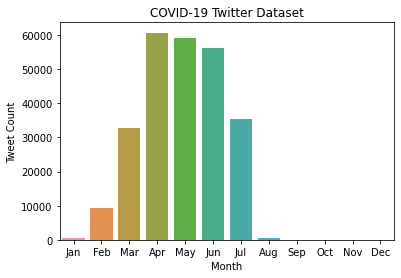

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_val = []

for mth in months:
    if mth not in month_dict:
        month_val.append(0)
    else:
        month_val.append(month_dict[mth])

ax = sns.barplot(x=months, y=month_val)
ax.set_title('COVID-19 Twitter Dataset')
ax.set_ylabel('Tweet Count')
ax.set_xlabel('Month')

In [ ]:
import matplotlib.pylab as plt
import numpy as np
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# r_sorted = sorted(r_mth.items(),key =lambda x:months.index(x[0]))
r_sorted = {k: v for k, v in sorted(r_mth.items(), key=lambda x:months.index(x[0]))}
nr_sorted = {k: v for k, v in sorted(nr_mth.items(), key=lambda x:months.index(x[0]))}

labels = [month for month in months if month in r_sorted.keys()]
x = np.arange(len(labels))
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, r_sorted.values(), width, label='Rumour')
rects2 = ax.bar(x + width/2, nr_sorted.values(), width, label='Non rumour')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tweet count')
ax.set_title('Tweet count by rumour')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [ ]:
print(covid_data.get_tokens()[0])
print(covid_data.get_text(0))

{'id_str': '1272262651100434433', 'preds': 'non-rumour', 'tokens': ['according', 'new', 'york', 'times', 'warner', 'bros', 'wanted', 'delay', 'christopher', 'nolan', '#tenet', 'months', 'ago', 'due', 'pandemic', 'nolan', 'refused', 'listen', 'discussions', 'studio', 'kept', 'original', 'release', 'date', 'keep', 'nolan', 'happy']}
['According to the New York Times, Warner Bros. wanted to delay Christopher Nolan’s #Tenet months ago due to the COVID-19 pandemic but Nolan refused to listen to any discussions. The studio kept the original release date to “keep [Nolan] happy”. https://t.co/toqbGFdb7e']


In [4]:
import gensim
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc

covid_data_tokens = covid_data.get_tokens()
vectorizer = CountVectorizer(analyzer='word', tokenizer=dummy, preprocessor=dummy)

rumour_tokens = [ t['tokens'] for t in covid_data_tokens if t['preds'] == 'rumour' ]
non_rumour_tokens = [ t['tokens'] for t in covid_data_tokens if t['preds'] == 'non-rumour' ]

rumour_vect = vectorizer.fit_transform(rumour_tokens)
non_rumour_vect = vectorizer.fit_transform(non_rumour_tokens)

rumour_gen_dict = Dictionary(rumour_tokens)
non_rumour_gen_dict = Dictionary(non_rumour_tokens)

rumour_bow = [rumour_gen_dict.doc2bow(t) for t in rumour_tokens]
non_rumour_bow = [non_rumour_gen_dict.doc2bow(t) for t in non_rumour_tokens]

In [ ]:
print(vectorizer.get_feature_names())

['##arrestbillgates', '##blueangels', '##chinavirus', '##cnn', '##coronavirus', '##covid19', '##covidー19', '##derelictionofduty', '##desantiskillsflorida', '##donaldtrump', '##donthecon', '##hesnoordinaryjoe', '##jokeofapresident', '##kkk', '##maga', '##obamagate', '##onlinemarketing', '##religionofpeace', '##scasksfauci', '##stayhome', '##tablighijamat', '##trumpkills', '##trumpvirus', '##trumpviruscatastrophe', '#0bamagate', "#1's", '#1--united', '#100000americansdeadontrumpswatch', '#100000dead', '#100000deadamericans', '#100000deadandcounting', '#100000deathsandcounting', '#100000kdeaths', '#1000xworse', '#100billion', '#100days', '#100daysofcode', '#100daystogo', '#100k', '#100kcovid19deaths', '#100kdead', '#100kdeadamericans', '#100kdeathonhishands', '#100kdeaths', '#100kplusdeaths', '#100ktarget', '#100ktrumpdeathtollrises', '#100kusadeaths', '#100thounsandsdeaths', '#100thousanddead', '#100yearsdeadlyevents', '#101waystoplay', '#103000deadamericans', '#10bforventilatorsnotbbi',

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [5, 10, 15, 20, 30, 40, 50, 60]}

skl_lda = LatentDirichletAllocation()
rumour_grid = GridSearchCV(skl_lda, param_grid=search_params)
non_rumour_grid = GridSearchCV(skl_lda, param_grid=search_params)

rumour_grid.fit(rumour_vect)
non_rumour_grid.fit(non_rumour_vect)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [6]:
# Saving gridCV to a file
import joblib

# save your model or results
joblib.dump(rumour_grid, root_path + 'rumour_grid_lda_skl.pkl')
joblib.dump(non_rumour_grid, root_path + 'non_rumour_grid_lda_skl.pkl')

# load your model for further usage
# joblib.load("model_file_name.pkl")

['/content/drive/My Drive/comp90042-project1/project-data/non_rumour_grid_lda_skl.pkl']

In [7]:
best_rumour_skl_lda = rumour_grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", rumour_grid.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", rumour_grid.best_score_)

# Perplexity
print("Model Perplexity: ", best_rumour_skl_lda.perplexity(rumour_vect))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -225252.7833691013
Model Perplexity:  4676.304839870526


In [8]:
best_non_rumour_skl_lda = non_rumour_grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", non_rumour_grid.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", non_rumour_grid.best_score_)

# Perplexity
print("Model Perplexity: ", best_non_rumour_skl_lda.perplexity(non_rumour_vect))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -6159139.119200988
Model Perplexity:  4451.079314705105


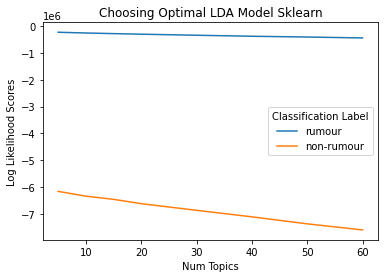

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

rumour_grid_score = rumour_grid.cv_results_['mean_test_score']
non_rumour_grid_score = non_rumour_grid.cv_results_['mean_test_score']

n_topics = [5, 10, 15, 20, 30, 40, 50, 60]

# Show graph
# plt.figure(figsize=(12, 8))
plt.plot(n_topics, rumour_grid_score, label='rumour')
plt.plot(n_topics, non_rumour_grid_score, label='non-rumour')
plt.title("Choosing Optimal LDA Model Sklearn")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Classification Label', loc='best')
plt.show()

In [11]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

rumour_vect = vectorizer.fit_transform(rumour_tokens)
rumour_topics_skl = show_topics(vectorizer, best_rumour_skl_lda, 15)
print(rumour_topics_skl)

non_rumour_vect = vectorizer.fit_transform(non_rumour_tokens)
non_rumour_topics_skl = show_topics(vectorizer, best_non_rumour_skl_lda, 15)
print(non_rumour_topics_skl)

[array(['trump', 'us', 'people', 'americans', 'like', 'war', 'get',
       'deaths', 'virus', 'death', 'president', 'pandemic', 'dead',
       'american', 'response'], dtype='<U49'), array(['cases', 'people', 'deaths', 'death', 'new', 'trump', 'positive',
       'us', 'virus', 'one', 'many', 'testing', 'get', 'china', 'tested'],
      dtype='<U49'), array(['people', 'china', 'world', '#wuhanvirus', 'would', 'help', 'home',
       'outbreak', 'minister', 'due', 'like', 'navy', 'roosevelt',
       'chinese', 'uss'], dtype='<U49'), array(['people', 'pandemic', 'trump', 'get', 'positive', 'like', 'tested',
       'us', 'one', 'president', 'virus', 'cases', 'deaths', 'going',
       'would'], dtype='<U49'), array(['wuhan', 'positive', 'lab', 'china', 'virus', 'would', 'people',
       'news', 'tested', 'get', 'lockdown', 'cotton', 'breaking',
       'originated', 'masks'], dtype='<U49')]
[array(['cases', 'new', 'mask', 'people', 'india', 'masks', 'please', 'us',
       'sir', 'wear', 'death

In [12]:
# print(rumour_topics_skl[0])

with open(root_path + 'rumour_skl_topics.txt', 'w') as outfile:
    for r in rumour_topics_skl:
        print(r, file=outfile)

with open(root_path + 'non_rumour_skl_topics.txt', 'w') as outfile:
    for nr in non_rumour_topics_skl:
        print(nr, file=outfile)

In [13]:
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

rumour_coherence = dict()
non_rumour_coherence = dict()
rumour_topics_gen = dict()
non_rumour_topics_gen = dict()

search_params = {'num_topics': [5, 10, 15, 20, 30, 40, 50, 60]}

for param in search_params['num_topics']:
    rumour_gen_lda = LdaMulticore(rumour_bow,
                                num_topics=param,
                                id2word=rumour_gen_dict,
                                workers=2,
                                random_state=69,
                                passes=10,
                                chunksize=100)
    
    non_rumour_gen_lda = LdaMulticore(non_rumour_bow,
                                      num_topics=param,
                                      id2word=non_rumour_gen_dict,
                                      workers=2,
                                      random_state=69,
                                      passes=10,
                                      chunksize=100)
    
    rumour_coherence[param] = CoherenceModel(rumour_gen_lda,
                                             texts=rumour_tokens,
                                             dictionary=rumour_gen_dict
                                             ).get_coherence()
    
    non_rumour_coherence[param] = CoherenceModel(non_rumour_gen_lda,
                                                 texts=non_rumour_tokens,
                                                 dictionary=non_rumour_gen_dict
                                                 ).get_coherence()
    
    print("num_topics " + str(param) + " is finished!")
    
    rumour_topics_gen[param] = {'Topic_' + str(i+1): [t for t, score in rumour_gen_lda.show_topic(i, topn=15)] for i in range(0, rumour_gen_lda.num_topics)}
    non_rumour_topics_gen[param] = {'Topic_' + str(i+1): [t for t, score in non_rumour_gen_lda.show_topic(i, topn=15)] for i in range(0, non_rumour_gen_lda.num_topics)}

num_topics 5 is finished!
num_topics 10 is finished!
num_topics 15 is finished!
num_topics 20 is finished!
num_topics 30 is finished!
num_topics 40 is finished!
num_topics 50 is finished!
num_topics 60 is finished!


In [16]:
with open(root_path + 'rumour_topics_gen.txt', 'w') as outfile:
    json.dump(rumour_topics_gen, outfile)

with open(root_path + 'rumour_topics_gen_coherence.txt', 'w') as outfile:
    json.dump(rumour_coherence, outfile)

with open(root_path + 'non_rumour_topics_gen.txt', 'w') as outfile:
    json.dump(non_rumour_topics_gen, outfile)

with open(root_path + 'non_rumour_topics_gen_coherence.txt', 'w') as outfile:
    json.dump(non_rumour_coherence, outfile)

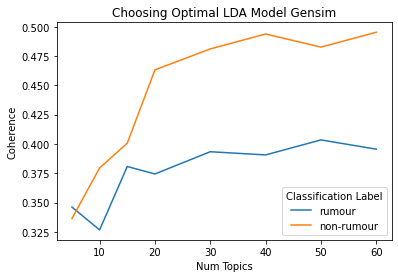

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

rum_coherence_list = [v for k,v in rumour_coherence.items()]
non_rum_coherence_list = [v for k,v in non_rumour_coherence.items()]

n_topics = [5, 10, 15, 20, 30, 40, 50, 60]

# Show graph
# plt.figure(figsize=(12, 8))
plt.plot(n_topics, rum_coherence_list, label='rumour')
plt.plot(n_topics, non_rum_coherence_list, label='non-rumour')
plt.title("Choosing Optimal LDA Model Gensim")
plt.xlabel("Num Topics")
plt.ylabel("Coherence")
plt.legend(title='Classification Label', loc='best')
plt.show()

In [15]:
print(rumour_coherence)

{5: 0.3461327837432378, 10: 0.32663029813028727, 15: 0.3807453817723558, 20: 0.37436350958451764, 30: 0.39335078975560384, 40: 0.3906254787199142, 50: 0.40343628491285377, 60: 0.3955225336799061}


In [17]:
import pandas as pd

rum_topics_df = pd.DataFrame.from_dict(rumour_topics_gen, orient='index')
non_rum_topics_df = pd.DataFrame.from_dict(non_rumour_topics_gen, orient='index')

In [65]:
rum_topics_df

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59,Topic_60
5,"[nursing, positive, home, tested, homes, patie...","[positive, tested, get, tests, home, breaking,...","[cases, new, people, confirmed, nigeria, lockd...","[pandemic, us, trump, people, get, like, ameri...","[trump, people, deaths, death, virus, us, like...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,"[nursing, home, homes, patients, china, positi...","[positive, tested, tests, cats, breaking, #bai...","[cases, new, refund, state, total, breaking, d...","[war, us, start, iran, trump, distract, world,...","[people, deaths, death, trump, virus, us, chin...","[nigeria, positive, cases, state, miller, scho...","[tested, positive, death, people, died, said, ...","[positive, cases, wuhan, people, tested, sympt...","[trump, pandemic, americans, us, people, presi...","[positive, test, tested, get, tests, virus, pe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,"[nursing, home, homes, patients, positive, eld...","[airport, first, city, among, club, law, offic...","[state, kogi, cases, governor, case, said, bel...","[oregon, mail-in, july, would, economic, want,...","[people, trump, deaths, us, like, virus, death...","[symptoms, cotton, positive, virus, tested, go...","[trump, people, beaten, death, killed, positiv...","[positive, cases, tested, nigeria, new, one, p...","[pandemic, focus, mail, vote, tests, pardon, a...","[cats, epicentre, healing, overwhelmed, site, ...","[schools, school, positive, testing, going, st...","[cases, new, infected, increasing, table, tenn...","[positive, tested, test, tainted, prevention, ...","[go, home, secondary, refund, insufficient, fi...","[war, us, start, trump, iran, distract, americ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,"[nursing, home, homes, patients, positive, eld...","[cats, #bailouthumans, cat, positive, tested, ...","[cases, state, new, kogi, breaking, total, gov...","[monkeys, wuhan, positive, samples, attacking,...","[trump, people, americans, us, like, president...","[cummings, infected, rules, reporters, dominic...","[killed, positive, floyd, george, death, autop...","[war, wuhan, us, iran, start, shoot, trump, na...","[mail, vote, ballots, fraud, hydroxychloroquin...","[mask, facts, hoax, gas, gaetz, matt, person, ...","[schools, students, school, positive, kids, te...","[nigeria, cases, discharged, god, state, lagos...","[game, transmission, human, sky, new, reports,...","[refund, cash, players, positive, voucher, ema...","[pandemic, trump, us, focus, americans, presid...","[people, deaths, cases, death, get, positive, ...","[drivers, truck, home, fight, go, uganda, oxyg...","[trump, rally, hoax, president, lie, people, s...","[trump, miller, white, stephen, house, pence, ...","[china, virus, cases, test, positive, new, bor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,"[positive, tested, players, prince, staff, lak...","[#bailouthumans, help, lost, job, due, po

In [68]:
for top in rum_topics_df.iloc[4]:
    print(top)

['positive', 'tested', 'players', 'prince', 'staff', 'lakers', 'tests', 'care', 'results', 'facility', 'breaking', 'symptoms', 'sources', 'companies', 'today']
['#bailouthumans', 'help', 'lost', 'job', 'due', 'positive', 'confirmed', 'work', 'people', 'negative', 'weeks', 'tests', 'league', 'get', 'tested']
['kogi', 'state', 'governor', 'bello', 'case', 'said', 'thought', 'app', "there's", 'may', 'denying', 'denial', 'yahaya', 'according', 'finally']
['drawn', 'ministry', 'today', 'masks', 'fire', 'statement', 'health', 'media', 'full', 'dhhs', 'gloves', 'recovery', 'tony', 'criticism', 'gamefreak']
['people', 'want', 'day', 'would', 'citizens', 'us', 'lockdown', 'cult', 'reopened', 'till', 'drivers', 'brown', 'economic', 'like', 'truck']
['oxygen', 'ill', 'critically', '6th', 'extended', 'friend', 'suspected', 'infectious', 'given', '#hydroxychloroquine', 'distress', 'patients', 'shit', 'treatment', 'drug']
['tested', 'ny', 'positive', 'skeptical', 'members', 'says', 'trump', 'former'

In [20]:
non_rum_topics_df

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59,Topic_60
5,"[china, virus, world, us, wuhan, government, p...","[people, get, like, deaths, would, death, one,...","[trump, americans, deaths, us, people, preside...","[state, nursing, patients, homes, new, texas, ...","[help, india, sir, please, due, #contest, #tmo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,"[vaccine, dr, flu, fauci, patients, cure, dise...","[people, get, like, would, one, know, go, viru...","[trump, americans, us, president, people, pand...","[mask, masks, people, nursing, homes, wear, pa...","[#contest, #tmobiletuesdays, #itelsaysstaysafe...","[help, please, india, sir, pandemic, due, figh...","[china, virus, wuhan, government, world, chine...","[bill, money, relief, democrats, pelosi, billi...","[#getusppe, nigeria, god, africa, lagos, malar...","[deaths, cases, death, new, testing, numbers, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,"[flu, vaccine, people, death, virus, dr, patie...","[people, like, get, one, know, would, going, v...","[trump, americans, president, us, people, pand...","[nursing, homes, patients, state, bill, people...","[#contest, #tmobiletuesdays, cain, herman, dan...","[india, sir, pandemic, please, fight, lockdown...","[mask, get, wear, children, masks, go, school,...","[#healthcareheroes, spray, 23rd, yo, article, ...","[#getusppe, disinfectant, bleach, light, #coro...","[deaths, cases, new, numbers, death, states, n...","[china, virus, wuhan, chinese, world, #wuhanvi...","[testing, world, tests, countries, test, us, c...","[help, god, due, family, please, would, work, ...","[government, uk, lockdown, march, people, john...","[players, post-coronavirus, season, nfl, clean...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,"[people, get, like, go, one, mask, going, viru...","[deaths, death, people, died, flu, many, know,...","[trump, us, president, americans, people, pand...","[nursing, patients, homes, state, governor, ho...","[safe, happy, champion, #coronakidney, birthda...","[father, dad, daddy, tesla, #healthcareheroes,...","[vaccine, dr, fauci, virus, new, flu, health, ...","[spray, climate, defeat, change, air, swimming...","[disinfectant, cure, bleach, light, nurse, dri...","[cases, deaths, new, states, florida, number, ...","[help, money, pandemic, bill, work, need, due,...","[countries, italy, africa, germany, south, cou...","[god, please, thank, nigeria, pray, help, bles...","[government, uk, lockdown, home, johnson, bori...","[india, sir, please, lockdown, fight, pandemic...","[china, virus, wuhan, chinese, world, #wuhanvi...","[#contest, #tmobiletuesdays, students, exam, u...","[trump, americans, dead, people, rally, vote, ...","[test, tested, testing, tests, positive, sympt...","[5g, ccp, planned, alleged, cell, withholding,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,"[vaccine, dr, fauci, patients, drug, hydroxych...","[people, like, get, go, would, one, going

In [69]:
for top in non_rum_topics_df.iloc[4]:
    print(top)

['vaccine', 'dr', 'fauci', 'patients', 'drug', 'hydroxychloroquine', 'treatment', 'cure', 'use', 'doctors', 'study', 'medical', 'virus', 'disease', 'health']
['people', 'like', 'get', 'go', 'would', 'one', 'going', 'think', 'us', 'know', 'want', 'virus', 'right', 'see', 'stop']
['trump', 'president', 'us', 'pandemic', 'response', 'testing', 'americans', 'said', 'america', 'hoax', 'administration', 'china', 'american', 'country', 'states']
['nursing', 'homes', 'patients', 'state', 'governor', 'cuomo', 'ny', 'home', 'new', 'york', 'elderly', 'gov', 'seniors', 'order', 'governors']
['died', 'churches', 'church', 'loved', 'cain', 'easter', 'herman', 'share', 'birthday', 'passed', 'religious', 'alive', '#thetrumpvirus', 'happy', 'pizza']
["who've", 'ar', 'gohmert', 'council', 'louie', 'pf', 'efficient', 'reveal', 'cbs', 'applied', 'utility', 'survey', 'doh', 'ng', 'abba']
['children', 'school', 'kids', 'schools', 'parents', 'safe', 'teachers', 'child', 'open', 'back', 'risk', 'paul', 'reope

In [ ]:
row_tweet = covid_df.iloc[1]
for tweet in row_tweet:
    if tweet == None:
        break
    print(tweet['user'])

tweet_data = ['created_at', 'id_str', 'text', 'retweet_count', 'favorite_count', 'user', 'entities']
tweet_user_data = ['verified', 'location', 'followers_count', 'friends_count', 'statuses_count']
tweet_entities_data = ['hashtags'] # iterate later for each hashtag take the 'text'


{'id': 44513878, 'id_str': '44513878', 'name': 'Texas Tribune', 'screen_name': 'TexasTribune', 'location': 'Austin, Texas', 'description': 'A member-supported, nonpartisan newsroom informing & engaging Texans on state politics & policy. Subscribe: https://t.co/7vzWxFt29b', 'url': 'https://t.co/6AlMrCkhsV', 'entities': {'url': {'urls': [{'url': 'https://t.co/6AlMrCkhsV', 'expanded_url': 'http://www.texastribune.org', 'display_url': 'texastribune.org', 'indices': [0, 23]}]}, 'description': {'urls': [{'url': 'https://t.co/7vzWxFt29b', 'expanded_url': 'http://trib.it/subscribe', 'display_url': 'trib.it/subscribe', 'indices': [108, 131]}]}}, 'protected': False, 'followers_count': 248090, 'friends_count': 59111, 'listed_count': 5053, 'created_at': 'Thu Jun 04 01:37:46 +0000 2009', 'favourites_count': 3126, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 94186, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_

In [ ]:
# Importing covid predictions
import json

COVID_PRED_PATH = root_path + 'covid-output.json'

with open(COVID_PRED_PATH, 'r') as inputfile:
    covid_preds = json.load(inputfile)

print(covid_preds)

{'1272262651100434433': 'non-rumour', '1287153210990395392': 'non-rumour', '1266555444283179008': 'non-rumour', '1257715199655755779': 'non-rumour', '1274338812173393920': 'non-rumour', '1278703879828303877': 'non-rumour', '1249421782630772746': 'non-rumour', '1274091468890632192': 'non-rumour', '1278159404324405248': 'non-rumour', '1283500526450159616': 'non-rumour', '1275627556289511424': 'non-rumour', '1257250378514526208': 'non-rumour', '1265729173961748480': 'non-rumour', '1265536236191731715': 'non-rumour', '1252660417341485060': 'non-rumour', '1239213982243868672': 'rumour', '1262904939086516225': 'non-rumour', '1242502830918979585': 'rumour', '1275522992672509952': 'non-rumour', '1264422394732527616': 'non-rumour', '1258433414291734529': 'non-rumour', '1275965523625418753': 'non-rumour', '1247303589501992962': 'non-rumour', '1280522599869579264': 'rumour', '1245128889116102658': 'non-rumour', '1242954004914524160': 'non-rumour', '1274036638042198017': 'non-rumour', '12779812354

In [ ]:
covid_data_list = []

REPLY_ID = 'in_reply_to_status_id_str'
TEXT = 'text'
ID = 'id_str'

TWEET_DATA = ['created_at', 'text', 'retweet_count', 'favorite_count']
TWEET_USER_DATA = ['verified', 'location', 'followers_count', 'friends_count', 'statuses_count']

for index, row_tweet in covid_df.iterrows():
    replies_list = []
    tweet_data = dict()
    source = dict()
    for tweet in row_tweet:
        replies = dict()
        if tweet == None:
            tweet_data[tweet_ID]['replies'] = replies_list
            covid_data_list.append(tweet_data)
            break
        if tweet[REPLY_ID] == None:
            tweet_ID = tweet[ID]
            tweet_data[tweet[ID]] = dict()
            source['user'] = dict()
            for data in TWEET_DATA:
                source[data] = tweet[data]
            for data in TWEET_USER_DATA:
                source['user'][data] = tweet['user'][data]
            hashtag_list = [ h['text'] for h in tweet['entities']['hashtags'] ]
            source['hashtags'] = hashtag_list
            tweet_data[tweet_ID]['source'] = source
        else:
            replies['user'] = dict()
            for data in TWEET_DATA:
                replies[data] = tweet[data]
            for data in TWEET_USER_DATA:
                replies['user'][data] = tweet['user'][data]
            hashtag_list = [ h['text'] for h in tweet['entities']['hashtags'] ]
            replies['hashtags'] = hashtag_list
            replies_list.append(replies)

print(covid_data_list[:5])

[{'1272262651100434433': {'source': {'user': {'verified': False, 'location': 'Worldwide', 'followers_count': 26179, 'friends_count': 18, 'statuses_count': 2512}, 'created_at': 'Sun Jun 14 20:20:28 +0000 2020', 'text': 'According to the New York Times, Warner Bros. wanted to delay Christopher Nolan’s #Tenet months ago due to the COVID-19 pandemic but Nolan refused to listen to any discussions. The studio kept the original release date to “keep [Nolan] happy”. https://t.co/toqbGFdb7e', 'retweet_count': 28, 'favorite_count': 280, 'hashtags': ['Tenet']}, 'replies': []}}, {'1287153210990395392': {'source': {'user': {'verified': True, 'location': 'Austin, Texas', 'followers_count': 248090, 'friends_count': 59111, 'statuses_count': 94186}, 'created_at': 'Sat Jul 25 22:30:14 +0000 2020', 'text': 'Hurricane Hanna has made landfall in Texas.\n\nThe storm is hitting a section of the Texas coast already reeling from thousands of coronavirus cases. https://t.co/KWL3awKW00', 'retweet_count': 545, 'f

In [24]:
print('dont die')

dont die
